# Tutorial: How to run erro mitigated state reconstruction.

## Import files and libraries

In [1]:
# Make sure we can import EMQST_lib from parent directory
import sys
from pathlib import Path

# Go two levels up from current working directory
PROJECT_ROOT = Path.cwd().resolve().parents[1]   # <- one up (your earlier case)


if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("Using project root:", PROJECT_ROOT)

# Notebook is in project-root/Multiplexed_qubit_readout_results/
# -> project root is the parent of the current working dir
PROJECT_ROOT = Path.cwd().resolve().parent


if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


import numpy as np
import scipy as sp
from scipy.stats import unitary_group
from datetime import datetime
import matplotlib.pyplot as plt
import qutip as qt
#from scipy.optimize import curve_fit
import os
import uuid
from itertools import repeat, chain, product, combinations
from joblib import Parallel, delayed
import time
from EMQST_lib import support_functions as sf
from EMQST_lib import emqst
from EMQST_lib.qst import QST  
from EMQST_lib.povm import POVM
from EMQST_lib import dt
from EMQST_lib import measurement_functions as mf
from EMQST_lib import visualization as vis
from EMQST_lib import overlapping_tomography as ot
from functools import reduce
from cvxopt import matrix, solvers
%load_ext autoreload
%autoreload 2

Using project root: C:\Users\adrian\OneDrive\Skrivebord\PhD\Code\REMQST


## Example of how to run Benchamking on REM. 
Define operational parameters for the simulation and error mitigation.

In [3]:
bool_exp_measurements = False # Whether to call experimental sampling function or not
n_qubits = 1
n_QST_shots = 10**3 # Number of shots for each spin measurement pr true state (total=3^n_qubits*n_QST_shots nativly) If = 0 no QST will be performed. 
n_calibration_shots = 10**3 # Calibration shots for DT, each calibration state and each spin measurment
n_cores = 8 # Available cores for parallell resampling of BME
n_averages = 5 # Only used if you generate true states generate_random_pure_state()
method="BME" # Defines what type of state reconstruction can be done, either "MLE" or "BME" (BME supports only 2 qubits).
calibration_mode = "SIC"
perform_unmitigated_QST = False # Reconstruct the quantum state with the same data, but without corrections.


noise_mode = 0 # Noise mode if using synthetic measurement
# For 1 qubit
# 0: No noise
# 1: Depolarizing noise
# 2: Stronger depolarized noise
# 3: Amplitude damping
# 4: Constant rotation around x-axis

# For 2 qubits:
# 0: No noise
# 1: CNOT noise
# 2: ISWAP noise
# 3: Constant random rotation
# 4: Constant factorized rotation
# 5: Small facotrized overrotation
# 6: Small x rotation only on first qubit
# 7: Strong depolarizing


synthetic_name_list = ["CNOT","ISWAP" ,"2_qubit_random_rotation", 
                       "facotrized_2_qubit_random_rotation", "small_factorized_overrotation",
                       "x-axis_first_qubit","2_qubit_depolarizing"]
# For more than 2 qubits: 
# Any non-zero is depolarizing noise


# Generating (Haar) random n-qubit pure states. (Contains entangled states)
list_of_true_states = np.array([sf.generate_random_pure_state(n_qubits) for _ in range(n_averages)])

# Generating factorizie n-qubit pure states (q_0 x q_1 x ... x q_n-1) where each single qubit is Haar random.
list_of_true_states, list_of_true_state_angles = sf.generate_random_factorized_states(n_qubits,n_averages)

#print(list_of_true_states)
#print(list_of_true_state_angles)
# If you want to connect your own experiment, you need to define a measurement function
# and supply it with the experimental dictionary. The experimetnal dictionary will be passed
# to the experimental measurement function, which should contain all parameters required to run
# the experiment.

# Example of the experimental measurement function.
 
def exp_measurement_function(n_shots,POVM_angles,true_state_angles,exp_dictionary):

    """
    It takes in:
    - n_shots as an int
    - POVM_angles (spin measuremnt angles on the Bloch sphere) 
    as n_possilbe_outcomes (2**n_qubits) x n_qubits x 2 (theta,phi) np.array
    e.g. for 2 qubits :  [ [ [theta_1,phi_1] (up) , [theta_1, phi_1] (up) ] (outcome 1) , [ [theta_1,phi_1] (up), [theta_2,phi_2] (down)] (outcome 2), ... ]
    - true state angles as n_qubits x 2 (theta, phi) np.array 
    e.g. for 2 qubits:  [ [theta_1,phi_1], [theta_2,phi_2] ]

    return: 
    np array with index of the outcomes corresponding POVM that occured. 
    e.g. for 2 qubits with outcome [(up up), (up, down), (down,up), (up,down)] is [0, 3, 2, 1]
    """
    #print(n_shots)
    #print(POVM_angles)
    #print(true_state_angles)
    return np.random.randint(low=0,high=2**n_qubits,size=(n_shots))

# All experimental parametres needed should be added to the experimetnal dictionary. 
exp_dictionary = {"standard_measurement_function": exp_measurement_function }

Running the default simulation.

In [4]:
# Calling the error mitigated QST. The function returns the set of mitigated and unmitigated infidelities
# for comparison. It alo supplies the list of error mitigated state estimates.
# In addition all run parameters are saved to a files in result.
results = emqst.emqst(n_qubits, n_QST_shots, n_calibration_shots,
                       list_of_true_states, bool_exp_measurements = bool_exp_measurements,
                       exp_dictionary = exp_dictionary,
                       n_cores = n_cores, noise_mode = noise_mode,calibration_mode = calibration_mode, 
                       true_state_angles_list = list_of_true_state_angles, method = method, perform_unmitigated_QST = perform_unmitigated_QST)


Created results dictionary.
Starting EMQST.
----------------------------
Error corrected BME.
POVM calibration states are SIC.
1 qubit(s).
Total shot count using spin measurements: 
12,000 POVM calibration shots.
3,000 QST shots.
5 QST averages.
----------------------------
No synthetic noise.
Done collecting and sorting QDT data, total runtime 0.0.
Starting POVM reconstruction.
Runtime of parallel POVM reconstruction 5.778154611587524
Runtime of DT reconstruction 5.779158115386963
Distance between reconstructed and noisy POVM: 0.011852629732075903
Distance between reconstructed and noisy POVM: 0.032161277757499135
Distance between reconstructed and noisy POVM: 0.013766101919447105
POVM calibration complete.
----------------------------
Generated data.
Start corrected QST.
Completed run 1/5. Final infidelity: 0.004111974625567005.
Completed run 2/5. Final infidelity: 0.008772130004574441.
Completed run 3/5. Final infidelity: 0.0036211031974460184.
Completed run 4/5. Final infidelity: 0

Work with the results

In [24]:

# Check what is stored in the results
key_list = list(results.keys())
print(f"List of keys {key_list}")
# Select the list of elements you want
index = 3 # Select the reconstructed POVM.

result_I_want = results[key_list[index]]
print(result_I_want.shape)
rho = results["corrected_rho_estm"]
#print(rho)
#print(np.trace(rho[0]@rho[0]))
# The reconstructed POVM has the following form. 
# The first index selects what spin-measurement was reconstructed, it follows the pattern 
# XX, XY, XZ, YX ... in total 9. 
# The second indes gives the outcome, and follows pattern (up up), (up down), (down up), (down down), 
# The last two dimension are the matrix dimensions. 

# Example, I want to look at the post-measurement state from outcome (up down) in XX direction. 
#M = result_I_want[8,0]
#print(M)
inf = results[key_list[0]]
uninf = results[key_list[1]]
print(inf)
print(uninf)
recon_POVM = results[key_list[4]]
print(recon_POVM)

# sampled_POVM = results["reconstructed_POVM"]
# path = 'data/synthetic_sampled_povms/'
# name = synthetic_name_list[noise_mode-1]
# np.save(path+name+".npy",result_I_want)

# sythetic_POVM = results["synthetic_POVM"]
# path2 = 'data/synthetic_exact_povms/'
# np.save(path2+name+".npy",sythetic_POVM)

List of keys ['corrected_infidelity', 'uncorrected_infidelity', 'corrected_rho_estm', 'uncorrected_rho_estm', 'reconstructed_POVM', 'synthetic_POVM']
(0,)
[]
[]
[[[[ 4.94237548e-01-9.97719447e-18j  4.98650847e-01-5.87796729e-03j]
   [ 4.98650847e-01+5.87796729e-03j  5.03173551e-01-1.01475540e-17j]]

  [[ 5.05762452e-01-5.46725668e-20j -4.98650847e-01+5.87796729e-03j]
   [-4.98650847e-01-5.87796729e-03j  4.96826449e-01+1.40016722e-19j]]]


 [[[ 4.89906747e-01-4.06479035e-19j  3.32632221e-03-4.97239790e-01j]
   [ 3.32632221e-03+4.97239790e-01j  5.05001840e-01-3.40382341e-19j]]

  [[ 5.10093253e-01-2.84508772e-20j -3.32632221e-03+4.97239790e-01j]
   [-3.32632221e-03-4.97239790e-01j  4.94998160e-01-2.17655621e-19j]]]


 [[[ 9.99991095e-01-5.12301226e-21j -2.97139642e-03-2.75276666e-04j]
   [-2.97139642e-03+2.75276666e-04j  1.06147641e-05-1.03487190e-21j]]

  [[ 8.90506845e-06-7.96606573e-24j  2.97139642e-03+2.75276666e-04j]
   [ 2.97139642e-03-2.75276666e-04j  9.99989385e-01-6.50370757e-23

Visualization

In [ ]:

vis.plot_POVM_folder(path2)

Plotting POVM lists from data/synthetic_exact_povms/.
2_qubit_depolarizing
2_qubit_random_rotation
CNOT
facotrized_2_qubit_random_rotation
ISWAP
small_factorized_overrotation
x-axis_first_qubit


1

## Example: How to perform QDT of specific spin basis.

In [2]:
# Define angle basis for QDT. 
bool_exp_measurements = False # Whether to call experimental sampling function or not
n_qubits = 2
n_calibration_shots = 10**4 # Calibration shots for DT, each calibration state and each spin measurment
n_cores = 8 # Available cores for parallell resampling of BME
calibration_mode = "SIC"
calibration_states, calibration_angles = sf.get_calibration_states(n_qubits,calibration_mode)
X = np.array([np.pi/2,0])
Y = np.array([np.pi/2,np.pi/2])
Z = np.array([0,0])
povm_angles = np.array([[X,X], [X,Y], [X,Z],[Y,X], [Y,Y], [Y,Z], [Z,X], [Z,Y], [Z,Z]])
        
pauli_povm = np.array([povm.get_POVM() for povm in POVM.generate_Pauli_POVM(n_qubits)])

# Example of the experimental measurement function.
def exp_measurement_function(n_shots,POVM_angles,true_state_angles,exp_dictionary):

    """
    It takes in:
    - n_shots as an int
    - POVM_angles (spin measuremnt angles on the Bloch sphere) 
    as n_possilbe_outcomes (2**n_qubits) x n_qubits x 2 (theta,phi) np.array
    e.g. for 2 qubits :  [ [ [theta_1,phi_1] (up) , [theta_1, phi_1] (up) ] (outcome 1) , [ [theta_1,phi_1] (up), [theta_2,phi_2] (down)] (outcome 2), ... ]
    - true state angles as n_qubits x 2 (theta, phi) np.array 
    e.g. for 2 qubits:  [ [theta_1,phi_1], [theta_2,phi_2] ]

    return: 
    np array with index of the outcomes corresponding POVM that occured. 
    e.g. for 2 qubits with outcome [(up up), (up, down), (down,up), (up,down)] is [0, 3, 2, 1]
    """
    #print(n_shots)
    #print(POVM_angles)
    #print(true_state_angles)
    return np.random.randint(low=0,high=2**n_qubits,size=(n_shots))

# All experimental parametres needed should be added to the experimetnal dictionary. 
exp_dictionary = {"standard_measurement_function": exp_measurement_function }

POVM_list = [POVM.POVM_from_angles(angles) for angles in povm_angles]
#print(POVM_list[0].get_POVM())

reconstructed_POVM_list = dt.device_tomography(n_qubits, n_calibration_shots, POVM_list, 
                                               calibration_states, n_cores = n_cores, 
                                               bool_exp_meaurements = bool_exp_measurements, 
                                               exp_dictionary = exp_dictionary, 
                                               initial_guess_POVM = POVM_list, 
                                               calibration_angles = calibration_angles)

# Check if the reconstruction find the correct states
for i in range(len(reconstructed_POVM_list)):
    print(f'{sf.POVM_distance(pauli_povm[i],reconstructed_POVM_list[i].get_POVM())}')

Done collecting and sorting QDT data, total runtime 0.04818224906921387.
Starting POVM reconstruction.
Runtime of parallel POVM reconstruction 14.454364776611328
0.006908320196696079
0.006508557052575581
0.005502993085723218
0.006607020721961829
0.005088492089089791
0.005370422597452025
0.005011755830300953
0.006895153856366756
0.004630655461040217


## Example: How to compute BME infidelity uncertainty (variance in infidelity).

In [15]:
load_from_data = True # If to load it or run a fresh data set.
path_to_data_folder = "results/2024-10-11_16-02-12_bf9a890a-868d-4af8-aa57-4775473a8f3e"


if load_from_data:
    # Load QST_settings data
    qst = QST.load_data(path_to_data_folder+"/")
    # Load DT setting to access QREM POVM.
    with open(f'{path_to_data_folder}/DT_settings.npy','rb') as f:
        povm_dict = np.load(f,allow_pickle=True).item()
    #print(povm_dict)
    recon_POVM_array = povm_dict["reconstructed_POVM_matrix"]
    #print(recon_POVM_array.shape)
    recon_povm = [POVM(recon_POVM_array[i]) for i in range(recon_POVM_array.shape[0])]
        
    
else: # Create new set of measurements
    n_qubits = 2
    pauli_6 = POVM.generate_Pauli_POVM(n_qubits)
    true_states = np.array([sf.generate_random_pure_state(n_qubits) for _ in range(2)])
    n_shots = 1000
    qst = QST(pauli_6,true_states,n_shots,n_qubits,False,{})
    qst.generate_data()

# Define sample points at which to evaluate uncertainy
uncertainty_points = np.array([100,1000,-1]) # -1 means to compute the final point. If point is outside the scope of the data, no point will be computed.
# The results will be found in the appropriate entry in the uncertainty array.

# Compute uncertainty
qst.perform_BME(override_POVM_list = recon_povm, compute_uncertainty = uncertainty_points)
uncertainty = qst.get_uncertainty()
print(f'Uncertianties {uncertainty[:,uncertainty_points]}')

print(f'Example of how to extract an averaged varaince of a spesific uncertainy.')
# The uncertainty is stored in as the last entry in the uncertaunty for each state that is averaged. 
uncertinty_point = uncertainty_points[1]

print(f'selected uncertainties: {uncertainty[:,uncertinty_point]}')

# If one wants the averaged variance
averaged_variance = np.mean(uncertainty[:,uncertinty_point], axis=0)
# If one wants the average standard deviation of the variance
std_variance = np.mean(np.sqrt(uncertainty[:,uncertinty_point]), axis=0)

print(f'Averaged variance: {averaged_variance}\nAveraged standard deviation of the variance: {std_variance}')

infidelity = qst.get_infidelity()
averaged_fidelity = np.mean(infidelity[:,uncertinty_point], axis=0)
print(f'Averaged infidelity with standard deviation would be: {averaged_fidelity} +- {std_variance} ')



print(f'-----------------------------------------------------------')
print(f'Display them all at once by setting uncertainty_point = {uncertainty_points}')
uncertinty_point = uncertainty_points
print(f'selected uncertainties: {uncertainty[:,uncertinty_point]}')

# If one wants the averaged variance
averaged_variance = np.mean(uncertainty[:,uncertinty_point], axis=0)
# If one wants the average standard deviation of the variance
std_variance = np.mean(np.sqrt(uncertainty[:,uncertinty_point]), axis=0)

print(f'Averaged variance: {averaged_variance}\nAveraged standard deviation of the variance: {std_variance}')

infidelity = qst.get_infidelity()
averaged_fidelity = np.mean(infidelity[:,uncertinty_point],axis = 0)
print(f'Averaged infidelity with standard deviation would be: {averaged_fidelity} +- {std_variance} ')

Loaded QST settings from results/2024-10-11_16-02-12_bf9a890a-868d-4af8-aa57-4775473a8f3e/
Completed run 1/5. Final infidelity: 0.009534385430094106.
Completed run 2/5. Final infidelity: 0.021748697349028512.
Completed run 3/5. Final infidelity: 0.008531058585431461.
Completed run 4/5. Final infidelity: 0.004760291737936018.
Completed run 5/5. Final infidelity: 0.013203508315229984.
Uncertianties [[8.74809540e-04 2.05356005e-05 8.64872358e-06]
 [6.28060221e-04 1.72056026e-05 8.80854020e-06]
 [1.09819768e-03 1.83589885e-05 6.78191966e-06]
 [1.47542312e-03 1.31346128e-05 3.16199759e-06]
 [4.13657314e-04 2.74283204e-05 5.99040716e-06]]
Example of how to extract an averaged varaince of a spesific uncertainy.
selected uncertainties: [2.05356005e-05 1.72056026e-05 1.83589885e-05 1.31346128e-05
 2.74283204e-05]
Averaged variance: 1.933262495573867e-05
Averaged standard deviation of the variance: 0.004365140201768308
Averaged infidelity with standard deviation would be: 0.015887846006568097 +-

## Computational basis error mitigation

Not Physical, correcting marginal
     pcost       dcost       gap    pres   dres
 0: -4.6164e-01 -1.5803e+00  1e+00  0e+00  3e+00
 1: -4.8155e-01 -5.4454e-01  6e-02  1e-16  1e-01
 2: -4.9984e-01 -5.0757e-01  8e-03  2e-16  3e-03
 3: -5.0292e-01 -5.0399e-01  1e-03  2e-16  7e-17
 4: -5.0337e-01 -5.0350e-01  1e-04  1e-16  6e-17
 5: -5.0346e-01 -5.0347e-01  1e-05  2e-16  6e-17
 6: -5.0347e-01 -5.0347e-01  8e-07  1e-16  3e-17
 7: -5.0347e-01 -5.0347e-01  3e-08  2e-16  8e-17
Optimal solution found.
Measured marginal :
[0.018 0.024 0.001 0.003 0.403 0.447 0.054 0.05 ]
Inital corrected marginal :
[-0.00727475  0.00385505 -0.00170525  0.00136016  0.44131109  0.55539804
  0.01776428 -0.01070863]
Physical marginal :
[9.19648100e-09 1.45750994e-05 3.10990481e-08 2.08530192e-07
 4.36481675e-01 5.50568623e-01 1.29348711e-02 6.55732638e-09]
True marginal :
[0.  0.  0.  0.  0.5 0.5 0.  0. ]
Distance between physical and true marginal : 0.08221359011271588


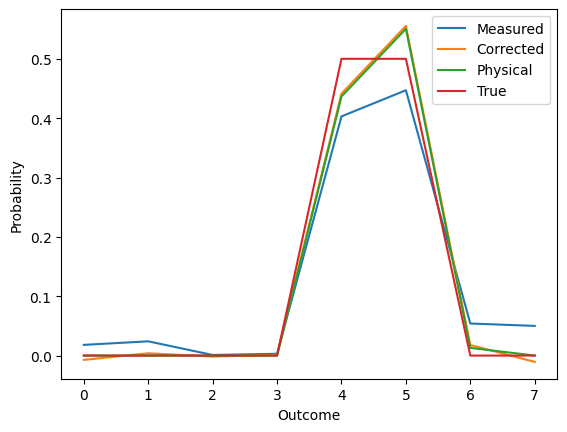

In [ ]:

#np.random.seed(0)
# To define some nessecary functions. 
# To check that probability marginal is physical
def is_marginal_physical(marginal):
    # Checks if marginal probability vector is physical. Checks if all elements are positive and if the sum is 1.
    return np.all(marginal>=0) and np.isclose(np.sum(marginal),1,atol=1e-5)

# Measurements only needs to be in the form of frequencies, i.e. n_i/N.
def probability_marginal_measurements(n_shots, povm, rho):
    return_frequencies = True
    marginal = mf.simulated_measurement(n_shots,povm,rho,return_frequencies)/n_shots
    # Put whatever else you want here....
    #print(rho)
    # Return should be on the form p = [n_0/N, n_1/N, ... , n_{2^n_qubits-1}/N]
    return marginal

def plot_matrix(matrix):
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.show()
    
def plot_distributions(distributions,names):
    """
    Plots a list of probability distributions.
    
    Parameters:
    - distributions (list): A list of probability distributions. Each distribution should be a list or numpy array of probabilities.
    
    Returns:
    - None
    """
    for i, distribution in enumerate(distributions):
        plt.plot(distribution, label=f"{names[i]}")
    
    plt.xlabel("Outcome")
    plt.ylabel("Probability")
    plt.legend()
    plt.show()


# Define nessecary parameters
n_qubits = 3
mode = "Comp"
n_QDT_shots = 10**4
n_observable_shots = 10**3
exp_dict = {}
pauli_states = sf.get_calibration_states(n_qubits,mode)[0]
comp_POVM = POVM.generate_computational_POVM(n_qubits)[0]
pauli_angles = comp_POVM.get_angles()
#print(pauli_angles)
# Measurement angles and comp basis and probability marginals
# follow the order [000, 001, 010, 011, ... , 111]	


# For numerical testing, create the noisy POVM
noise1 = POVM.depolarized_POVM(POVM.generate_computational_POVM(1)[0],0.2)
noise2 = POVM.depolarized_POVM(POVM.generate_computational_POVM(1)[0],0.1)
noise3 = POVM.depolarized_POVM(POVM.generate_computational_POVM(1)[0],0.5)
composite_noise = POVM.tensor_POVM(POVM.tensor_POVM(np.array([noise2]), np.array([noise1])),np.array([noise3]))
noise_comp = POVM.depolarized_POVM(POVM.generate_computational_POVM(n_qubits)[0],0.1)

# Define the state you want to measure (IDK how you specify the system you want to measure)
rho1 = np.array([[1,1],[1,1]])*1/2  
rho2 = np.array([[1,0],[0,0]])
rho3 = np.array([[0,0],[0,1]])
rho_sample = np.kron(np.kron(rho3,rho2),rho1)
#rho_sample = sf.generate_random_pure_state(n_qubits)

# Calibrate the confusion matrix, makes 8 calls for the 8 pauli states
C_meaured = np.array([probability_marginal_measurements(n_QDT_shots, composite_noise[0], rho) for rho in pauli_states]).T

# Measure the probability marginal of intrest
exp_marginal = probability_marginal_measurements(n_observable_shots, composite_noise[0], rho_sample)

# Compute the inverted confusion matrix and initial corrected marginal
C_measured_inv = np.linalg.inv(C_meaured)
# plot_matrix(C_meaured)
# plot_matrix(C_measured_inv)
#plot_matrix(np.dot(C_measured_inv,C_meaured))
corrected_marginal = np.real(np.einsum('ij,j->i',C_measured_inv, exp_marginal))

# For numerics
comp_POVM = comp_POVM.get_POVM()
true_marginal = np.real(np.einsum('ijk,kj->i',comp_POVM,rho_sample))


# Check if it needs to be further corrected, e.g. for real entries
if is_marginal_physical(corrected_marginal):
    print("Physical")
    physical_marginal = corrected_marginal
    
else: 
    n = 2**n_qubits
    print("Not Physical, correcting marginal")
    # Define solver parameters (using cvxopt)
    P = 2*matrix(np.eye(n))
    q = matrix(-2*corrected_marginal)
    G = matrix(0.0, (n,n))
    G[::n+1] = -1.0
    h = matrix(0.0, (n,1))
    A = matrix(1.0, (1,n))
    b = matrix(1.0)
    sol = solvers.qp(P,q,G,h,A,b)
    #print(sol['x'])
    #print(np.array(sol['x']))
    physical_marginal = np.array(sol['x']).flatten()
print(f'Measured marginal :\n{exp_marginal}')
print(f'Inital corrected marginal :\n{corrected_marginal}')    
print(f'Physical marginal :\n{physical_marginal}')
#print(np.sum(physical_marginal))
print(f'True marginal :\n{true_marginal}')
print(f'Distance between physical and true marginal : {np.linalg.norm(physical_marginal-true_marginal)}')

plot_distributions([exp_marginal, corrected_marginal, physical_marginal, true_marginal],names=["Measured","Corrected","Physical","True"])


## Example how to run comparative REM with same data. 

Explcite walkthrough of how the data downconversion works. 

In [ ]:

n_qubits = 1
    
print("Downconversion happens in 3 steps;") 
print(" 1) Outcomes")
print(" 2) Calibration states")
print(" 3) POVMs")
# n_qubits is the target qubit size. 

print("Step by step explaination of what happenes. Initial list created simplified 2 qubit structure." )
arr=np.reshape(np.arange(9*12*4),(9,12,4))
print( "Array has shape 9*12*4,  9 POVMs (xx, xy, ..) 12 calibration states, 4 outcomes (for simplicity)" )

print(f'Select outcome of first POVM (XX) \n{arr[0]}')
print("Sum over calibration states (They go x+x+, x+x- ,...) so every 6.")
print(np.array([np.sum(arr[0,j::6**n_qubits],axis=0) for j in range(6**n_qubits) ]))
print("Perform for each of these rows sum over every second outcome")
print(np.array([np.sum(np.array([np.sum(arr[0,j::6**n_qubits],axis=0)[k::2**n_qubits] for k in range(2**n_qubits)]),axis=1) for j in range(6**n_qubits) ]))
    
print("Now do this for each of the POVMS separatly")    
arr_2 = np.array([np.array([np.sum(np.array([np.sum(arr[k,i::6**n_qubits],axis=0)[j::2**n_qubits] for j in range(2**n_qubits)]),axis=1) for i in range(6**n_qubits)]) for k in range(len(arr))])
print(arr_2)

# Downconvert POVM
print("In the final step we need to downconver the POVMs, XX, XY, XZ, YX, so every 3rd POVM should be summed")
arr_3 = np.array([np.sum(arr_2[i::3**n_qubits],axis=0) for i in range(3**n_qubits)])
print(arr_3)



def downconvert_QDT_counts(index_counts,to_qubits,):
    arr_1 = np.array([np.array([np.sum(np.array([np.sum(index_counts[k,i::6**to_qubits],axis=0)[j::2**to_qubits] for j in range(2**to_qubits)]),axis=1) for i in range(6**to_qubits)]) for k in range(len(index_counts))])
    arr_2 = np.array([np.sum(arr_1[i::3**to_qubits],axis=0) for i in range(3**to_qubits)])
    return arr_2




Downconversion happens in 3 steps;
 1) Outcomes
 2) Calibration states
 3) POVMs
Step by step explaination of what happenes. Initial list created simplified 2 qubit structure.
Array has shape 9*12*4,  9 POVMs (xx, xy, ..) 12 calibration states, 4 outcomes (for simplicity)
Select outcome of first POVM (XX) 
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]
 [20 21 22 23]
 [24 25 26 27]
 [28 29 30 31]
 [32 33 34 35]
 [36 37 38 39]
 [40 41 42 43]
 [44 45 46 47]]
Sum over calibration states (They go x+x+, x+x- ,...) so every 6.
[[24 26 28 30]
 [32 34 36 38]
 [40 42 44 46]
 [48 50 52 54]
 [56 58 60 62]
 [64 66 68 70]]
Perform for each of these rows sum over every second outcome
[[ 52  56]
 [ 68  72]
 [ 84  88]
 [100 104]
 [116 120]
 [132 136]]
Now do this for each of the POVMS separatly
[[[  52   56]
  [  68   72]
  [  84   88]
  [ 100  104]
  [ 116  120]
  [ 132  136]]

 [[ 244  248]
  [ 260  264]
  [ 276  280]
  [ 292  296]
  [ 308  312]
  [ 324  328]]

 [[ 436  4

In [ ]:
# Testing simultanious 2 and 1 qubit QDT
n_qubits=2
downconvert_to_qubits = 1
n_QDT_shots_each = 10**6 
n_QST_shots_each = 10**6
n_averages = 10
n_cores = 1
noise_mode = 2
exp_dictionary = {}
bool_exp_measurements = False

base_POVM_list = POVM.generate_Pauli_POVM(n_qubits)

noisy_POVM_list = np.array([POVM.depolarized_POVM(povm) for povm in base_POVM_list])

#noisy_POVM_list = np.array([POVM.generate_noisy_POVM(povm,noise_mode) for povm in base_POVM_list])
original_POVM, downconverted_POVM = dt.donwconverted_device_tomography(n_qubits, downconvert_to_qubits,n_QDT_shots_each,noisy_POVM_list,n_cores=n_cores)

print(original_POVM[0].get_POVM().shape)
print(downconverted_POVM[0].get_POVM().shape)



print("POVM calibration complete.\n----------------------------")

list_of_true_states_small = np.array([sf.generate_random_pure_state(downconvert_to_qubits) for _ in range(n_averages)])
list_of_true_states_large = np.array([np.kron(sf.generate_random_pure_state(n_qubits - downconvert_to_qubits),list_of_true_states_small[i]) for i in range(n_averages)])

#print(list_of_true_states_small.shape)
#print(list_of_true_states_large.shape)
qst_large = QST(POVM.generate_Pauli_POVM(n_qubits),list_of_true_states_large,n_QST_shots_each,n_qubits,bool_exp_measurements,exp_dictionary,n_cores=n_cores,noise_corrected_POVM_list=original_POVM)
qst_small = QST(POVM.generate_Pauli_POVM(downconvert_to_qubits),list_of_true_states_small,n_QST_shots_each*3,downconvert_to_qubits,bool_exp_measurements,exp_dictionary,n_cores=n_cores,noise_corrected_POVM_list=downconverted_POVM)
qst_large.generate_data(override_POVM_list=noisy_POVM_list)
outcomes = qst_large.get_outcomes()

qst_large.perform_MLE(override_POVM_list=original_POVM)
rho_large = qst_large.get_rho_estm()
infid_large = 1  - np.real(np.einsum('kij,kji->k',rho_large, list_of_true_states_large))

#print(infid_large)
# Downconvert the outcome indecies:
# We assume that we remove the first index, so we need to modulo the whole outcome set by 6. 
downconverted_outcomes = np.floor_divide(outcomes%12,2*2)*2  + (outcomes%12)%2
print(f'Large infidelity: {infid_large}\nAverage {np.average(infid_large)}')

qst_small.set_outcomes(downconverted_outcomes)

qst_small.perform_MLE(override_POVM_list=downconverted_POVM)

rho_small = qst_small.get_rho_estm()

rho_large_traced_down = np.einsum('nijil->njl', np.reshape(rho_large, (n_averages,2, 2, 2, 2)))

infid = 1 - np.real(np.einsum('kij,kji->k',rho_small,list_of_true_states_small))
print(f"Small infidelity: {infid}\nAverage {np.average(infid)}")

infid = 1 - np.real(np.einsum('kij,kji->k',rho_large_traced_down,list_of_true_states_small))
print(f"Traced down infidelity: {infid}\nAverage {np.average(infid)}")



Done collecting and sorting QDT data, total runtime 8.169024467468262.
Starting POVM reconstruction.
	Number of MLE iterations: 450, final distance 2.390697084742044e-10
	Number of MLE iterations: 450, final distance 2.6646712614208923e-10
	Number of MLE iterations: 450, final distance 9.45095945947827e-11
	Number of MLE iterations: 450, final distance 2.6197861935362e-10
	Number of MLE iterations: 500, final distance 8.789324823510469e-11
	Number of MLE iterations: 500, final distance 1.0007440709447479e-10
	Number of MLE iterations: 450, final distance 2.9443580212840104e-10
	Number of MLE iterations: 500, final distance 9.03015717756972e-11
	Number of MLE iterations: 450, final distance 1.3566179429824743e-10
Runtime of parallel POVM reconstruction 2.045966148376465
Starting downconverted POVM reconstruction.
	Number of MLE iterations: 50, final distance 1.478261957288396e-13
	Number of MLE iterations: 50, final distance 2.4659163599949352e-11
	Number of MLE iterations: 50, final di

In [ ]:
n_qubits=2
test = np.arange(6**n_qubits)
test=np.reshape(test,(9,4))
test2 = test%12
test3 = np.floor_divide(test2,2*n_qubits)*n_qubits  + test2%n_qubits

test4 = np.floor_divide(test%12,2*n_qubits)*n_qubits  + (test%12)%n_qubits
# for i in range(len(test)):
#     print(test[i])
#     print(test2[i])
#     print(test3[i])
#     print("")
    
print(test)
print(test4)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]
 [20 21 22 23]
 [24 25 26 27]
 [28 29 30 31]
 [32 33 34 35]]
[[0 1 0 1]
 [2 3 2 3]
 [4 5 4 5]
 [0 1 0 1]
 [2 3 2 3]
 [4 5 4 5]
 [0 1 0 1]
 [2 3 2 3]
 [4 5 4 5]]


In [ ]:
import numpy as np

def partial_trace(rho_2qubit):
    # Get the number of rows/columns of the 2-qubit density matrix
    n = int(np.sqrt(len(rho_2qubit)))
    
    # Reshape the 2-qubit density matrix to a 4D tensor
    rho_4d = np.reshape(rho_2qubit, (n, n, n, n))
    
    # Perform partial trace by summing over the second qubit
    rho_1qubit = np.einsum('ijil->jl', rho_4d)
    
    return rho_1qubit

# Example usage:
# Create a random 2-qubit density matrix
rho_2qubit = np.random.random((4, 4)) + 1j * np.random.random((4, 4))
rho_2qubit = rho_2qubit + np.conj(np.transpose(rho_2qubit))

# Normalize to ensure it is a valid density matrix
rho_2qubit /= np.trace(rho_2qubit)

# Perform partial trace over the first qubit
for i in range(len(list_of_true_states_large)):
    rho_1qubit = partial_trace(list_of_true_states_large[i])

    #list_of_true_states_small
    #list_of_true_states_large

    # Display the results
    print("2-qubit density matrix:")
    print(list_of_true_states_small[i])
    print("\n1-qubit density matrix (traced over the first qubit):")
    print(rho_1qubit)


2-qubit density matrix:
[[ 0.94844359+0.j         -0.01178186-0.22081561j]
 [-0.01178186+0.22081561j  0.05155641+0.j        ]]

1-qubit density matrix (traced over the first qubit):
[[ 0.94844359+0.j         -0.01178186-0.22081561j]
 [-0.01178186+0.22081561j  0.05155641+0.j        ]]
2-qubit density matrix:
[[0.6751816 +0.j         0.33777898-0.32437135j]
 [0.33777898+0.32437135j 0.3248184 +0.j        ]]

1-qubit density matrix (traced over the first qubit):
[[0.6751816 +0.j         0.33777898-0.32437135j]
 [0.33777898+0.32437135j 0.3248184 +0.j        ]]
2-qubit density matrix:
[[ 0.531662 +0.j         -0.4794405+0.13832687j]
 [-0.4794405-0.13832687j  0.468338 +0.j        ]]

1-qubit density matrix (traced over the first qubit):
[[ 0.531662 +0.j         -0.4794405+0.13832687j]
 [-0.4794405-0.13832687j  0.468338 +0.j        ]]
2-qubit density matrix:
[[ 0.02601935+0.j         -0.04616645-0.15235156j]
 [-0.04616645+0.15235156j  0.97398065+0.j        ]]

1-qubit density matrix (traced ov

## Example on how to run experimental only REM with custom measurement function for QST

In [ ]:
bool_exp_measurements = True # We will assume that everything here is experimental, no simulations attached.
n_qubits = 3
n_QST_shots = 10**5 # Number of shots for each spin measurement pr true state (total=3^n_qubits*n_QST_shots nativly)
n_calibration_shots = 10**5 # Calibration shots for DT, each calibration state and each spin measurment
n_cores = 1 # Available cores for parallell resampling of BME

# Numerical true state
numerical_rho_QST = sf.generate_random_pure_state(n_qubits)

def exp_measurement_function(n_shots,POVM_angles,true_state_angles,exp_dictionary):

    """
    It takes in:
    - n_shots as an int
    - POVM_angles (spin measuremnt angles on the Bloch sphere) 
    as n_possilbe_outcomes (2**n_qubits) x n_qubits x 2 (theta,phi) np.array
    e.g. for 2 qubits :  [ [ [theta_1,phi_1] (up) , [theta_1, phi_1] (up) ] (outcome 1) , [ [theta_1,phi_1] (up), [theta_2,phi_2] (down)] (outcome 2), ... ]
    - true state angles as n_qubits x 2 (theta, phi) np.array 
    e.g. for 2 qubits:  [ [theta_1,phi_1], [theta_2,phi_2] ]

    return: 
    np array with index of the outcomes corresponding POVM that occured. 
    e.g. for 2 qubits with outcome [(up up), (up, down), (down,up), (up,down)] is [0, 3, 2, 1]
    """
    #print(POVM_angles)
    #print(n_shots)
    #print(true_state_angles)
    # Functions needed for numerical simulations
    rho = sf.get_density_matrix_from_angles(true_state_angles)
    povm = POVM.POVM_from_angles(POVM_angles[0])
    
    return mf.simulated_measurement(n_shots,povm,rho)


def special_measurement_function(n_shots, POVM_angles, exp_dictionary):
    """Custom function that you pass for measurement, does not have a true state.

    Args:
        n_shots (int): number of shots for the POVM (spin measurement)
        POVM_angles (POVM): Angle representation for POVM, see exp_measurement_function for structure explaination.
        exp_dictionary (dict): _description_

    Returns:
        np.array: Set of outcomes. 
    """
    # Functions needed for numerical simulations
    povm = POVM.POVM_from_angles(POVM_angles[0]) 
    return mf.simulated_measurement(n_QST_shots,povm,numerical_rho_QST)
    

# All experimental parametres needed should be added to the experimetnal dictionary. 
exp_dictionary = {"standard_measurement_function": exp_measurement_function }


# Set up folder for data storage.
data_path = sf.initialize_estimation(exp_dictionary)

# Perfoms QDT with the standard_measurement_function (the old one which takes in angles for calibration and measurement)
reconstructed_POVM_list = dt.experimental_QDT(n_qubits,n_calibration_shots,exp_dictionary)

# Checks for numerical accuracy for POVMs
# pauli = POVM.generate_Pauli_POVM(n_qubits)
# for i in range(len(reconstructed_POVM_list)):
#     print(f"POVM_distance {sf.POVM_distance(reconstructed_POVM_list[i].get_POVM(),pauli[i].get_POVM())}")  

# Define the QST object. 
# The default POVM for experimental_QST is the Pauli-6, there is an optional arugment to pass a different default POVM.
# The default POVM defines the angles which you request forthe measurements. 
# Pauli_6 = POVM.generate_Pauli_POVM(n_qubits)
qst = QST.setup_experimental_QST(n_qubits, n_QST_shots, exp_dictionary)

# Generate data, here you HAVE TO pass the measurement function you want, otherwise it breaks. 
qst.generate_data(custom_measurement_function = special_measurement_function)

# Perform MLE, you can insert the corrected POVM by using the override_POVM_list command.
# If it is left empty it will use the defaul POVM, which we defined above to be the Pauli-6.  
qst.perform_MLE(override_POVM_list = reconstructed_POVM_list)
# To get out rho_estm use the command

rho_estm_corrected = qst.get_rho_estm()

# To get back the uncorrected rho just call perform_MLE again without overriding the POVM
qst.perform_MLE()
rho_estm_uncorrected = qst.get_rho_estm()


print(f'Corrected fidelity {np.einsum('ij,ji->',numerical_rho_QST,rho_estm_corrected[0])}' )
print(f'Uncorrected fidelity {np.einsum('ij,ji->', numerical_rho_QST,rho_estm_uncorrected[0])}')
#print(infidelity)


Done collecting and sorting QDT data, total runtime 14.927785396575928.
Starting POVM reconstruction.
	Number of MLE iterations: 50, final distance 4.049816038076415e-13
	Number of MLE iterations: 50, final distance 3.026745520884333e-13
	Number of MLE iterations: 50, final distance 7.940800794692393e-13
	Number of MLE iterations: 50, final distance 4.547126564169446e-13
	Number of MLE iterations: 50, final distance 3.841579832020159e-13
	Number of MLE iterations: 50, final distance 2.639902185741505e-13
	Number of MLE iterations: 50, final distance 3.490333022604375e-13
	Number of MLE iterations: 50, final distance 3.1820726609232963e-13
	Number of MLE iterations: 50, final distance 4.894071259364807e-13
	Number of MLE iterations: 50, final distance 2.8419627762232835e-13
	Number of MLE iterations: 50, final distance 6.225714388463643e-13
	Number of MLE iterations: 50, final distance 3.99555388774786e-13
	Number of MLE iterations: 50, final distance 3.553303484782333e-13
	Number of ML

## Further examples (Not tested for current release)


Example of simulating data and running QST: (Below this it is not tested)

In [ ]:
# Basic QST example
# We use a different POVM object, using pauli-6 looks like this
n_qubits=1
POVM_list=POVM.generate_Pauli_POVM(n_qubits)

# Define the estimator
qst=QST(POVM_list,list_of_true_states,n_QST_shots,1,bool_exp_measurements,exp_dictionary,n_cores=n_cores)

print("Start generating data.")
qst.generate_data()


print("Start QST.")
qst.perform_BME()
rho_estm=qst.get_rho_estm()
infidelity=qst.get_infidelity()
print(infidelity)
for i in range (len(infidelity)):
    plt.plot(infidelity[i])
plt.yscale('log')
plt.xscale('log')
plt.show()



AttributeError: 'QST' object has no attribute 'n_averages'

### Loading data and perform experiments again. 

Example of loading data from the QST_settings.npy
QST_settings contain the current working state of the QST class, which includes the data gathered, POVM reconstruction, resulting state reconstruction, shot by shot infidelities for both corrected and uncorrected reconstructions. 

Loaded QST settings from results/2023-12-01_11-32-15_a1982a66-4157-4e19-92a0-01604bb3b317/
Completed run 1/5. Final infidelity: 0.001955820515143092.
Completed run 2/5. Final infidelity: 0.0022101417696598347.
Completed run 3/5. Final infidelity: 0.0030173064882488276.
Completed run 4/5. Final infidelity: 0.008603452819664015.
Completed run 5/5. Final infidelity: 0.0024755943191250296.
Completed run 1/5. Final infidelity: 0.0016434212143887628.
Completed run 2/5. Final infidelity: 0.0034519433673005917.
Completed run 3/5. Final infidelity: 0.002639535379878377.
Completed run 4/5. Final infidelity: 0.004321753035997022.
Completed run 5/5. Final infidelity: 0.002613734816288349.


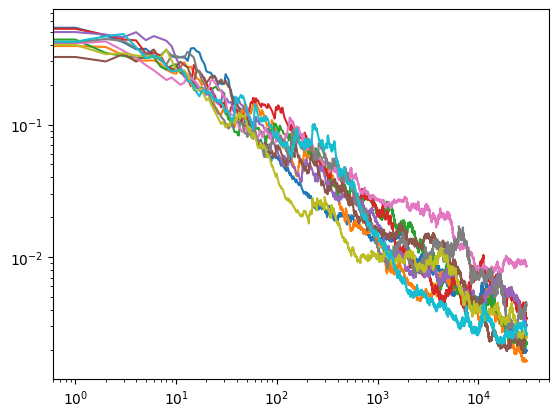

In [ ]:
# Load data from QST_settings.npy
base_path = "results/2023-12-01_11-32-15_a1982a66-4157-4e19-92a0-01604bb3b317/"
qst = QST.load_data(base_path)


# You can perform BME with the uncorrected POVM (default setting: Pauli-6)
qst.perform_BME()
uncorrected_infidelity = qst.get_infidelity()


# Perform BME with corrected POVM
use_corrected_POVM = True
qst.perform_BME(use_corrected_POVM)
corrected_infidelity = qst.get_infidelity()


for i in range (len(uncorrected_infidelity)):
    plt.plot(uncorrected_infidelity[i])
    plt.plot(corrected_infidelity[i])
plt.yscale('log')
plt.xscale('log')
plt.show()


Example of loading results directly from QST_results.npy

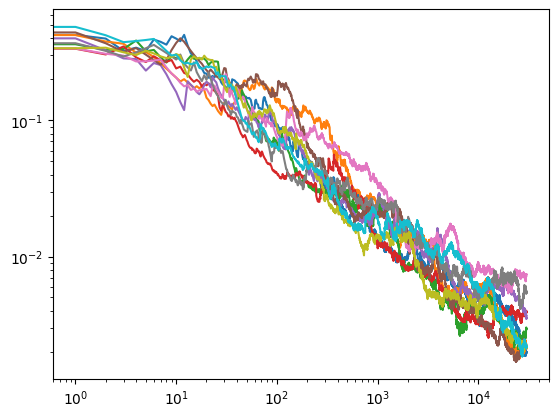

In [ ]:
base_path = "results/2023-12-01_11-32-15_a1982a66-4157-4e19-92a0-01604bb3b317/"

# The data is saved in the following order
with open(f'{base_path}/QST_results.npy','rb') as f:
    corrected_infidelity = np.load(f)
    uncorrected_infidelity = np.load(f)
    uncorrected_rho_est = np.load(f)
    corrected_rho_estm = np.load(f)
    
for i in range (len(uncorrected_infidelity)):
    plt.plot(uncorrected_infidelity[i])
    plt.plot(corrected_infidelity[i])
plt.yscale('log')
plt.xscale('log')
plt.show()
